# Data Transformations

**Introduction:**
Using the data gathered from Taarifa and the Tanzanian Ministry of Water, can we predict which pumps are functional, which need some repairs, and which don't work at all? Predicting one of these three classes based and a smart understanding of which waterpoints will fail, can improve the maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

This is also an intermediate-level competition by [DataDriven][1]! All code & support scripts are in [Github Repo][2]

[1]: https://www.drivendata.org/competitions/7/ "Link to Competetion Page"
[2]: https://github.com/msampathkumar/datadriven_pumpit "User Code"

In [1]:
import pickle
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.sam_value_counts import sam_dataframe_cols_value_count_analysis, sam_dataframe_markup_value_counts
from scripts.sam_confusion_matrix import sam_plot_confusion_matrix, sam_confusion_maxtrix
from scripts.sam_variance_check import get_low_variance_columns
from scripts.sam_custom_labeler import CUST_CATEGORY_LABELER
from scripts.tools import check_metric, data_transformations, df_check_stats, game, sam_pickle_load, sam_pickle_save

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

%matplotlib inline

np.set_printoptions(precision=5)
np.random.seed(69572)
plt.style.use('ggplot')
sns.set(color_codes=True)


crazy_list = dir()

In [2]:
for each in dir():
    if each not in crazy_list:
        del each

# Data Transformation

Normal Transformations
* Date
* Bool
* Longi, Lati missing values
* Longi, Lati precision check

In [3]:
# data collection
RAW_X = pd.read_csv('data/traning_set_values.csv', index_col='id')
RAW_y = pd.read_csv('data/training_set_labels.csv', index_col='id')
RAW_TEST_X = pd.read_csv('data/test_set_values.csv', index_col='id')

# df_check_stats(RAW_X, RAW_y, RAW_TEST_X)

strptime = datetime.datetime.strptime

DATE_FORMAT = "%Y-%m-%d"
REFERENCE_DATE_POINT = strptime('2000-01-01', DATE_FORMAT)

if RAW_X.date_recorded.dtype == 'O':

    # convert it to datetime format
    f = lambda x: strptime(str(x), DATE_FORMAT)
    RAW_X.date_recorded = RAW_X.date_recorded.apply(f)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.apply(f)

    # week day
    f = lambda x: x.weekday()
    RAW_X['date_recorded_weekday'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_weekday'] = RAW_TEST_X.date_recorded.apply(f)

    # date
    f = lambda x: x.day
    RAW_X['date_recorded_date'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_date'] = RAW_TEST_X.date_recorded.apply(f)

    # month
    f = lambda x: x.month
    RAW_X['date_recorded_month'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_month'] = RAW_TEST_X.date_recorded.apply(f)

    # year
    f = lambda x: x.year
    RAW_X['date_recorded_year'] = RAW_X.date_recorded.apply(f)
    RAW_TEST_X['date_recorded_year'] = RAW_TEST_X.date_recorded.apply(f)

    # total days
    f = lambda x: (x - REFERENCE_DATE_POINT).days
    RAW_X.date_recorded = RAW_X.date_recorded.apply(f)
    RAW_TEST_X.date_recorded = RAW_TEST_X.date_recorded.apply(f)

# GPS Height
RAW_X.gps_height[RAW_X.gps_height <= 5] = 0

# Longitude & Latitude -- zero values fix

# Filling Missing
if not RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'].empty:
    tmp = np.mean(RAW_X[u'latitude'][RAW_X.latitude < -1.0].values)
    RAW_X.loc[RAW_X.latitude >= -1.0, u'latitude'] = tmp
    RAW_TEST_X.loc[RAW_TEST_X.latitude >= -1.0, u'latitude'] = tmp


# Filling Missing
if not RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'].empty:
    tmp = np.mean(RAW_X[u'longitude'][RAW_X[u'longitude'] > 1.0].values)
    RAW_X.loc[RAW_X[u'longitude'] <= 1.0, u'longitude'] = tmp
    RAW_TEST_X.loc[RAW_TEST_X[u'longitude'] <= 1.0, u'longitude'] = tmp

    
# Reducing geo location precision to 11 meters
LONG_LAT_PRECISION = 0.00001
fns_lola =lambda x: (x//LONG_LAT_PRECISION) * LONG_LAT_PRECISION

# Reducing Precision of Lat.
RAW_X.longitude = RAW_X.longitude.map(fns_lola)
RAW_X.latitude = RAW_X.latitude.map(fns_lola)
RAW_TEST_X.longitude = RAW_TEST_X.longitude.map(fns_lola)
RAW_TEST_X.latitude = RAW_TEST_X.latitude.map(fns_lola)

###############################################################################
##### Note Below transformation are to make sure Label Encoding works fine ####
###############################################################################

# bool columns
tmp = ['public_meeting', 'permit']
RAW_X[tmp] = RAW_X[tmp].fillna(False)
RAW_TEST_X[tmp] = RAW_TEST_X[tmp].fillna(False)

# object columns list
obj_cols = RAW_X.dtypes[RAW_X.dtypes == 'O'].index.tolist()

# object columns
RAW_X[obj_cols] = RAW_X[obj_cols].fillna('Other')
RAW_TEST_X[obj_cols] = RAW_TEST_X[obj_cols].fillna('Other')


sam_pickle_save(RAW_X, RAW_y, RAW_TEST_X, prefix="tmp/Iteration2_dt1_")
df_check_stats(RAW_X, RAW_y, RAW_TEST_X)

/Users/sampathm/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


SAVE PREFIX USED:  tmp/Iteration2_dt1_
Data Frame Shape: (59400, 43) TotColumns: 43 ObjectCols: 0
Data Frame Shape: (59400, 1) TotColumns: 1 ObjectCols: 0
Data Frame Shape: (14850, 43) TotColumns: 43 ObjectCols: 0


In [4]:
# Just assining new names to transformed dataframe pointers
X, y, TEST_X = data_transformations(RAW_X, RAW_y, RAW_TEST_X, pickle_path='tmp/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)

# benchmark
clf = game(X_train, X_test, y_train, y_test, algo='rf', )

------------------------------------------------
AC Score: 0.985162738496 F1 Score: 0.985229315286
------------------------------------------------
AC Score: 0.800538720539 F1 Score: 0.80662530668


In [5]:
# benchmark
clf = game(X_train, X_test, y_train, y_test, algo='gb', )

------------------------------------------------
AC Score: 0.757822671156 F1 Score: 0.77973617372
------------------------------------------------
AC Score: 0.754882154882 F1 Score: 0.777529930132


In [6]:
for each in dir():
    if each not in crazy_list:
        del each

# Data Transformation

Normal Transformations
* Date
* Bool
* Longi, Lati missing values
* Longi, Lati precision check


# Data Transformation - 2nd Trail

* Custom Labler


In [7]:
RAW_X, RAW_y, RAW_TEST_X = sam_pickle_load(prefix="tmp/Iteration2_dt1_")
df_check_stats(RAW_X, RAW_y, RAW_TEST_X)

LOAD PREFIX USED:  tmp/Iteration2_dt1_
Data Frame Shape: (59400, 43) TotColumns: 43 ObjectCols: 0
Data Frame Shape: (59400, 1) TotColumns: 1 ObjectCols: 0
Data Frame Shape: (14850, 43) TotColumns: 43 ObjectCols: 0


In [8]:
def text_transformation(name):
    """Cleanup basic text issue in name(input).
    
    Removes text capitalisation, case, space and other non text ascii charecters
        except space.
    """
    if name:
        name = str(name).lower().strip()
        name = ''.join([i if 96 < ord(i) < 128 else ' ' for i in name])

        # clear double space
#         while '  ' in name:
#             name = name.replace('  ', ' ')
        name = name.replace(" ", "")
        return name.strip()
    return ''

for col in obj_cols:
    a, b, c = (col, len(RAW_X[col].value_counts()), len(RAW_TEST_X[col].value_counts()))
    RAW_X[col] = RAW_X[col].apply(text_transformation)
    RAW_TEST_X[col] = RAW_TEST_X[col].apply(text_transformation)
    d, e = len(RAW_X[col].value_counts()), len(RAW_TEST_X[col].value_counts())
    print(a, b - d, c - e)
    if col is 'installer': break

funder 27 15
installer 295 152
wpt_name 1146 227
basin 0 0
subvillage 207 76
region 0 0
lga 0 0
ward 2 0
recorded_by 0 0
scheme_management 0 0
scheme_name 217 98
extraction_type 0 0
extraction_type_group 0 0
extraction_type_class 0 0
management 0 0
management_group 0 0
payment 0 0
payment_type 0 0
water_quality 0 0
quality_group 0 0
quantity 0 0
quantity_group 0 0
source 0 0
source_type 0 0
source_class 0 0
waterpoint_type 0 0
waterpoint_type_group 0 0


In [9]:
# Just assining new names to transformed dataframe pointers
X, y, TEST_X = data_transformations(RAW_X, RAW_y, RAW_TEST_X, pickle_path='tmp/')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)

In [10]:
# benchmark
clf = game(X_train, X_test, y_train, y_test, algo='rf')

------------------------------------------------
AC Score: 0.985005611672 F1 Score: 0.985069945887
------------------------------------------------
AC Score: 0.801212121212 F1 Score: 0.808015256502


In [11]:
# benchmark
clf = game(X_train, X_test, y_train, y_test, algo='gb')

------------------------------------------------
AC Score: 0.756879910213 F1 Score: 0.778488552734
------------------------------------------------
AC Score: 0.754343434343 F1 Score: 0.776337580177


__Conclusion:__
* As you can see there is a slightly improvement in the RF AC score(0.012) given the data transformations.
* Also you can that the gap between GB scores have slightly reduced.(0.0004 in AC Test Train Scores)


### Custom Labler

In [12]:
##################################
######### IMPLEMENT ##############
#################################

custom_labler = defaultdict(CUST_CATEGORY_LABELER)
tmp = { 'funder': 97,
  'installer': 97,
  'wpt_name': 80,
  'subvillage': 80,
  'ward': 80,
  'scheme_name': 85
  }

for col, limit  in tmp.items():
    print('--------------------------------------------------------', col)
    labler = custom_labler[col]
    labler.DATA_COVERAGE_LIMIT = limit
    labler.fit(RAW_X[col])
    tmp = labler.fit_transform(RAW_X[col])
    print(len(RAW_X[col].value_counts()), len(tmp.value_counts()))
    RAW_X[col] = tmp
    tmp = labler.etransform(RAW_TEST_X[col])
    print(len(RAW_TEST_X[col].value_counts()), len(tmp.value_counts()))

print(RAW_X.shape, RAW_TEST_X.shape, all(RAW_X.columns == RAW_TEST_X.columns))

-------------------------------------------------------- wpt_name
80 percentage of DATA coverage mean, 24375 (in number) groups
36254 24376
80 percentage of DATA coverage mean, 24375 (in number) groups
10613 2231
-------------------------------------------------------- ward
80 percentage of DATA coverage mean, 997 (in number) groups
2090 998
80 percentage of DATA coverage mean, 997 (in number) groups
1959 992
-------------------------------------------------------- subvillage
80 percentage of DATA coverage mean, 8505 (in number) groups
19081 8506
80 percentage of DATA coverage mean, 8505 (in number) groups
8368 4294
-------------------------------------------------------- installer
97 percentage of DATA coverage mean, 591 (in number) groups
1851 592
97 percentage of DATA coverage mean, 591 (in number) groups
940 516
-------------------------------------------------------- funder
97 percentage of DATA coverage mean, 587 (in number) groups
1871 588
97 percentage of DATA coverage mean, 58

In [13]:
sam_pickle_save(RAW_X, RAW_y, RAW_TEST_X, prefix="tmp/Iteration2_dt2_")
df_check_stats(X, y, TEST_X)

SAVE PREFIX USED:  tmp/Iteration2_dt2_
Data Frame Shape: (59400, 43) TotColumns: 43 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 43) TotColumns: 43 ObjectCols: 0


In [14]:
# Just assining new names to transformed dataframe pointers
X, y, TEST_X = data_transformations(RAW_X, RAW_y, RAW_TEST_X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42, stratify=y)

In [15]:
# benchmark
clf = game(X_train, X_test, y_train, y_test, algo='rf', )

------------------------------------------------
AC Score: 0.985342312009 F1 Score: 0.985408921295
------------------------------------------------
AC Score: 0.800673400673 F1 Score: 0.806862879864


In [16]:
# benchmark
clf = game(X_train, X_test, y_train, y_test, algo='gb', )

------------------------------------------------
AC Score: 0.758451178451 F1 Score: 0.77953282745
------------------------------------------------
AC Score: 0.755420875421 F1 Score: 0.777454236688


In [17]:
sam_pickle_save(X, y, TEST_X, prefix="tmp/Iteration2_final_")
df_check_stats(X, y, TEST_X)

SAVE PREFIX USED:  tmp/Iteration2_final_
Data Frame Shape: (59400, 43) TotColumns: 43 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 43) TotColumns: 43 ObjectCols: 0


In [18]:
for each in dir():
    if each not in crazy_list:
        del each

# Analysis

Lets us check how did our data improvement worked till now. To summarise we have done two data transformation till now. First level of data transformation is minimal set of data transformation to make sure we can label encode the data. Second level of data transformaiton is some more data transformation and in the third level of data transformation we are concentrated in object columns to improve the data quality by reducing the entropy in data with out loss of much information.

In [19]:
X, y, TEST_X = sam_pickle_load(prefix="tmp/Iteration2_final_")
df_check_stats(X, y, TEST_X)

LOAD PREFIX USED:  tmp/Iteration2_final_
Data Frame Shape: (59400, 43) TotColumns: 43 ObjectCols: 0
Numpy Array Size: 59400
Data Frame Shape: (14850, 43) TotColumns: 43 ObjectCols: 0


In [26]:
names = ['Benchmark(Iteration2_dt1_)',
        'First DT',
        'Second DT(Iteration2_final_)']

gb_tr_scores = [0.757822671156, 0.756879910213, 0.758024691358]
gb_te_scores = [0.754882154882, 0.754343434343, 0.755218855219]
gb_diff = [ a -b for a,b in zip(gb_tr_scores, gb_te_scores)]

(array([ 0.    ,  0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025,  0.003 ]),
 <a list of 7 Text yticklabel objects>)

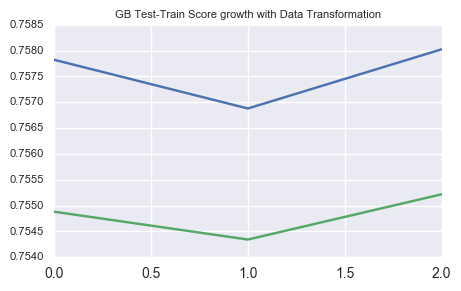

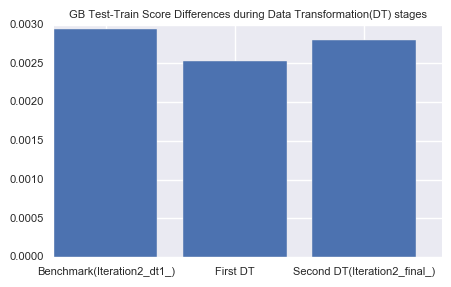

In [27]:
plt.figure(figsize=(5, 3))
plt.plot(range(3), gb_tr_scores)
plt.plot(range(3), gb_te_scores)
plt.title('GB Test-Train Score growth with Data Transformation', fontsize=8)
plt.yticks(fontsize=8)

plt.figure(figsize=(5, 3))
plt.bar(range(3), gb_diff)
plt.title('GB Test-Train Score Differences during Data Transformation(DT) stages', fontsize=8)
plt.xticks(np.arange(len(names)) + .4, names, fontsize=8)
plt.yticks(fontsize=8)

In [24]:
# rf - random forest

rf_tr_scores = [0.985162738496, 0.985005611672, 0.985342312009]
rf_te_scores = [0.800538720539, 0.801212121212, 0.800740740741]
rf_diff = [ a - b for a, b in zip(rf_tr_scores, rf_te_scores)]

(array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25]),
 <a list of 6 Text yticklabel objects>)

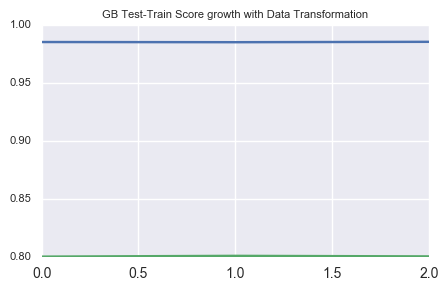

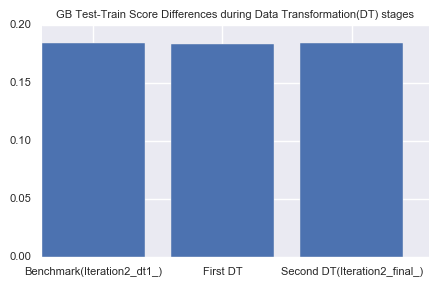

In [25]:
plt.figure(figsize=(5, 3))
plt.plot(range(3), rf_tr_scores)
plt.plot(range(3), rf_te_scores)
plt.title('GB Test-Train Score growth with Data Transformation', fontsize=8)
plt.yticks(fontsize=8)

plt.figure(figsize=(5, 3))
plt.bar(range(3), rf_diff)
plt.title('GB Test-Train Score Differences during Data Transformation(DT) stages', fontsize=8)
plt.xticks(np.arange(len(names)) + .4, names, fontsize=8)
plt.yticks(fontsize=8)

In [28]:
for each in dir():
    if each not in crazy_list:
        del each